<a href="https://colab.research.google.com/github/Awaish0419/VanillaOptionFiniteDifferencePDE/blob/main/VanillaOptionFiniteDifferencePDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation function of Vanilla options

## Explicit method

In [1]:
def calculate_prices_explicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S):
  delta_t = T / M
  delta_S = max_S / N

  import math

  values = [[0] * (M + 1) for _ in range(N + 1)]

  #　initial all edges.
  if isCall:
    # when t = T
    for i in range(N + 1):
      intrinsic_value = i * delta_S - K
      if (intrinsic_value > 0):
        values[i][M] = intrinsic_value
      else:
        values[i][M] = 0

    # when S = 0
    for i in range(M + 1):
      values[0][i] = 0

    # when S = max_S
    for i in range(M + 1):
      values[N][i] = max_S

  if (not isCall):
    # when t = T
    for i in range(N + 1):
      intrinsic_value = K - i * delta_S
      if (intrinsic_value > 0):
        values[i][M] = intrinsic_value
      else:
        values[i][M] = 0

    # when S = 0
    for i in range(M + 1):
      values[0][i] = K * math.exp(-r * (T - i * delta_t))

    # when S = max_S
    for i in range(M + 1):
      values[N][i] = 0

  # Algorithm
  for m in range(M - 1, -1, -1):
    for n in range(1, N, 1):
      p = (sigma * n) ** 2
      q = r * n
      d = 1 / 2 * delta_t * (p - q)
      l = 1 - r * delta_t - p * delta_t
      u = 1 / 2 * delta_t * (p + q)
      value = values[n-1][m+1] * d + values[n][m+1] * l + values[n+1][m+1] * u
      values[n][m] = value
      if (not isEuropean):  # American option
        this_intrinsic_value = 0
        if isCall:
          this_intrinsic_value = n * delta_S - K
        if (not isCall):
          this_intrinsic_value = K - n * delta_S
        if (value < this_intrinsic_value):
          values[n][m] = this_intrinsic_value

  prices = [0] * (N + 1)
  for n in range(N + 1):
    prices[n] = values[n][0]

  return prices

## Implicit method

In [2]:
def calculate_prices_implicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S):
  import math
  import numpy as np

  delta_t = T / M
  delta_S = max_S / N

  values = [[0] * (M + 1) for _ in range(N + 1)]

  #　initial all edges.
  if isCall:
    # when t = T
    for i in range(N + 1):
      intrinsic_value = i * delta_S - K
      if (intrinsic_value > 0):
        values[i][M] = intrinsic_value
      else:
        values[i][M] = 0

    # when S = 0
    for i in range(M + 1):
      values[0][i] = 0

    # when S = max_S
    for i in range(M + 1):
      values[N][i] = max_S

  if (not isCall):
    # when t = T
    for i in range(N + 1):
      intrinsic_value = K - i * delta_S
      if (intrinsic_value > 0):
        values[i][M] = intrinsic_value
      else:
        values[i][M] = 0

    # when S = 0
    for i in range(M + 1):
      values[0][i] = K * math.exp(-r * (T - i * delta_t))

    # when S = max_S
    for i in range(M + 1):
      values[N][i] = 0

  # Algorithm
  A = np.zeros((N-1, N-1))
  b = np.zeros((N-1))
  alpha = sigma**2 * delta_t
  beta = r * delta_t
  for m in range(M-1, -1, -1):
    # set b vector
    for i in range(N - 1):
      b[i] = values[i+1][m+1]
    b[0] -= (beta - alpha) / 2 * values[0][m]
    b[N-2] += (beta * (N-1) + (alpha * (N-1)**2)) / 2 * values[N][m]

    # set A matrix
    for n in range(N-1):
      if (n == 0):
        A[0, 0] = 1 + beta + alpha
        A[0, 1] = (- beta - alpha) / 2
      elif (n == N - 2):
        A[N-2, N-3] = (beta * (n + 1) - alpha * (n + 1) ** 2) / 2
        A[N-2, N-2] = 1 + beta + alpha * (n + 1) ** 2
      else:
        A[n, n-1] = (beta * (n + 1) - alpha * (n + 1) ** 2) / 2
        A[n, n] = 1 + beta + alpha * (n + 1) ** 2
        A[n, n+1] = (- beta * (n + 1) - alpha * (n + 1) ** 2) / 2

    # solve A * V(m) = V(m + 1) (Ax = b)
    x = np.linalg.solve(A, b)

    # copy solution to values matrix
    for n in range(N - 1):
      values[n+1][m] = x[n]
      if (not isEuropean):
        this_intrinsic_value = 0
        if isCall:
          this_intrinsic_value = (n + 1) * delta_S - K
        if (not isCall):
          this_intrinsic_value = K - (n + 1) * delta_S
        if (x[n] < this_intrinsic_value):
          values[n+1][m] = this_intrinsic_value

  prices = [0] * (N + 1)
  for n in range(N + 1):
    prices[n] = values[n][0]

  return prices


## Crank-Nicolson (semi-implicit method)

In [3]:
def calculate_prices_crank(T, r, sigma, K, M, N, isEuropean, isCall, max_S):
  import math
  import numpy as np

  delta_t = T / M
  delta_S = max_S / N

  values = [[0] * (M + 1) for _ in range(N + 1)]

  #　initial all edges.
  if isCall:
    # when t = T
    for i in range(N + 1):
      intrinsic_value = i * delta_S - K
      if (intrinsic_value > 0):
        values[i][M] = intrinsic_value
      else:
        values[i][M] = 0

    # when S = 0
    for i in range(M + 1):
      values[0][i] = 0

    # when S = max_S
    for i in range(M + 1):
      values[N][i] = max_S

  if (not isCall):
    # when t = T
    for i in range(N + 1):
      intrinsic_value = K - i * delta_S
      if (intrinsic_value > 0):
        values[i][M] = intrinsic_value
      else:
        values[i][M] = 0

    # when S = 0
    for i in range(M + 1):
      values[0][i] = K * math.exp(-r * (T - i * delta_t))

    # when S = max_S
    for i in range(M + 1):
      values[N][i] = 0

  # Algorithm
  A = np.zeros((N-1, N-1))
  b = np.zeros((N-1))
  alpha = sigma**2 * delta_t
  beta = r * delta_t
  for m in range(M-1, -1, -1):
    # set b vector
    for i in range(N - 1):
      b[i] = values[i+1][m+1]
    b[0] += alpha / 2 * values[0][m]
    b[N-2] += (beta * (N-1) + (alpha * (N-1)**2) / 2) * values[N][m]

    # set A matrix
    for n in range(N-1):
      if (n == 0):
        A[0, 0] = 1 + beta + beta + alpha
        A[0, 1] = - beta - alpha / 2
      elif (n == N - 2):
        A[N-2, N-3] = - alpha * (n + 1) ** 2 / 2
        A[N-2, N-2] = 1 + beta + beta * (n + 1) + alpha * (n + 1) ** 2
      else:
        A[n, n-1] = - alpha * (n + 1) ** 2 / 2
        A[n, n] = 1 + beta + beta * (n + 1) + alpha * (n + 1) ** 2
        A[n, n+1] = - beta * (n + 1) - alpha * (n + 1) ** 2 / 2

    # solve A * V(m) = V(m + 1) (Ax = b)
    x = np.linalg.solve(A, b)

    # copy solution to values matrix
    for n in range(N - 1):
      values[n+1][m] = x[n]
      if (not isEuropean):
        this_intrinsic_value = 0
        if isCall:
          this_intrinsic_value = (n + 1) * delta_S - K
        if (not isCall):
          this_intrinsic_value = K - (n + 1) * delta_S
        if (x[n] < this_intrinsic_value):
          values[n+1][m] = this_intrinsic_value

  prices = [0] * (N + 1)
  for n in range(N + 1):
    prices[n] = values[n][0]

  return prices


## Visualize the results.

In [4]:
import matplotlib.pyplot as plt

### Explicit method

#### European call option.

In [5]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = True
# Call or Put option
isCall = True
# max S
max_S = 3 * K

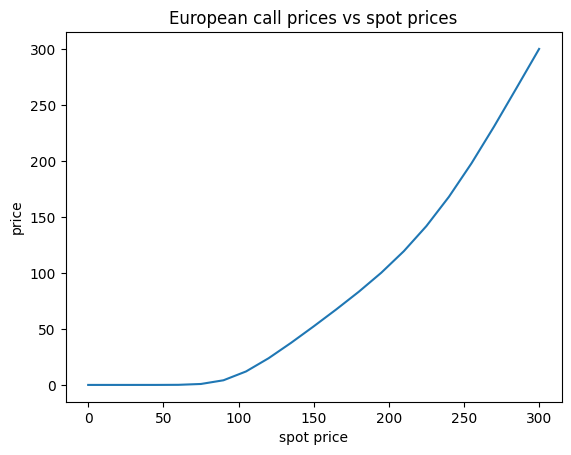

In [6]:
European_call_prices_explicit = calculate_prices_explicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, European_call_prices_explicit)

plt.title('European call prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### European put option

In [7]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = True
# Call or Put option
isCall = False
# max S
max_S = 3 * K

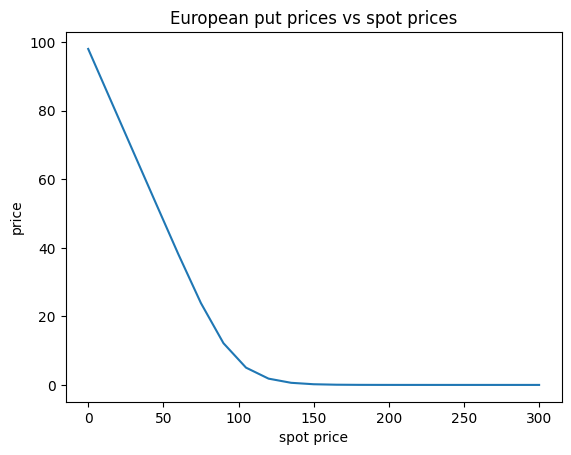

In [8]:
European_put_prices_explicit = calculate_prices_explicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, European_put_prices_explicit)

plt.title('European put prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### American call option

In [9]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = False
# Call or Put option
isCall = True
# max S
max_S = 3 * K

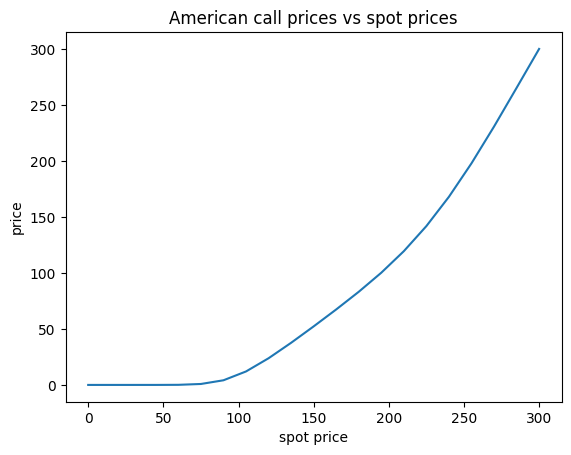

In [10]:
American_call_prices_explicit = calculate_prices_explicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, American_call_prices_explicit)

plt.title('American call prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### American put option

In [11]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = False
# Call or Put option
isCall = False
# max S
max_S = 3 * K

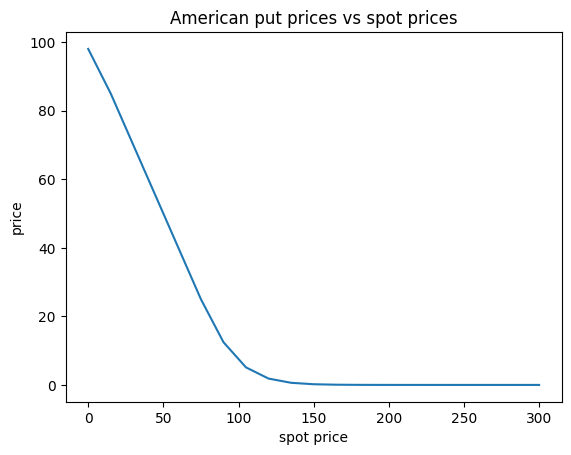

In [12]:
American_put_prices_explicit = calculate_prices_explicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, American_put_prices_explicit)

plt.title('American put prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

### Implicit method

#### European call option.

In [13]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = True
# Call or Put option
isCall = True
# max S
max_S = 3 * K

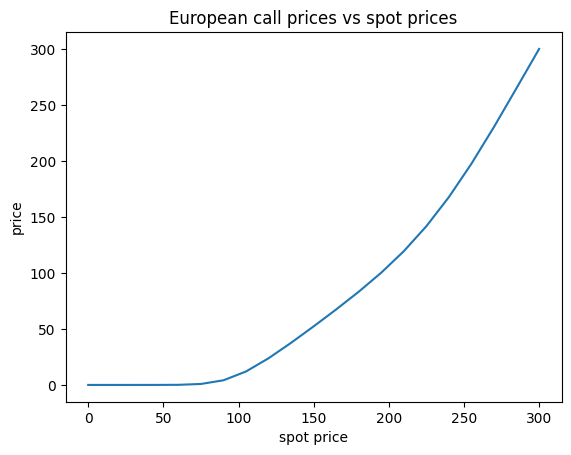

In [14]:
European_call_prices_implicit = calculate_prices_implicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, European_call_prices_implicit)

plt.title('European call prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### European put option

In [15]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = True
# Call or Put option
isCall = False
# max S
max_S = 3 * K

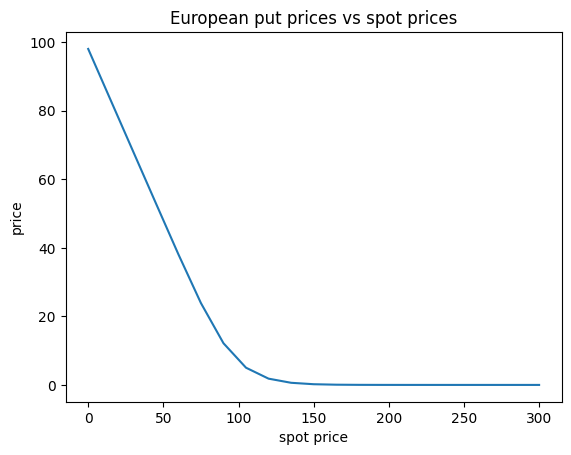

In [16]:
European_put_prices_implicit = calculate_prices_implicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, European_put_prices_implicit)

plt.title('European put prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### American call option

In [17]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = False
# Call or Put option
isCall = True
# max S
max_S = 3 * K

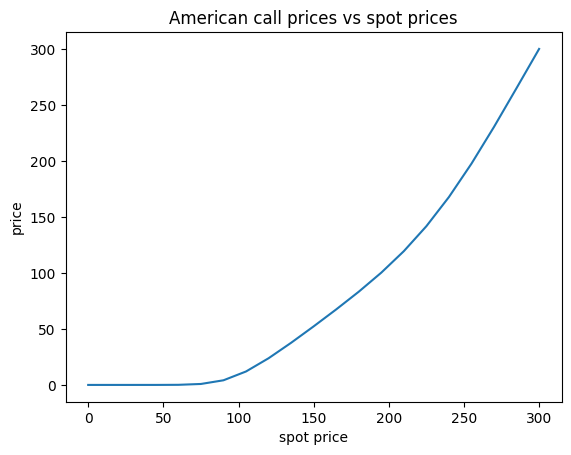

In [18]:
American_call_prices_implicit = calculate_prices_implicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, American_call_prices_implicit)

plt.title('American call prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### American put option

In [19]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = False
# Call or Put option
isCall = False
# max S
max_S = 3 * K

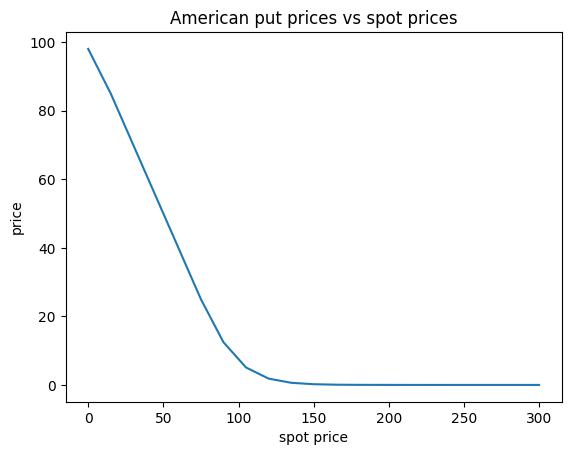

In [20]:
American_put_prices_implicit = calculate_prices_implicit(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, American_put_prices_implicit)

plt.title('American put prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

### Crank-Nicolson (semi-implicit method)

#### European call option.

In [21]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = True
# Call or Put option
isCall = True
# max S
max_S = 3 * K

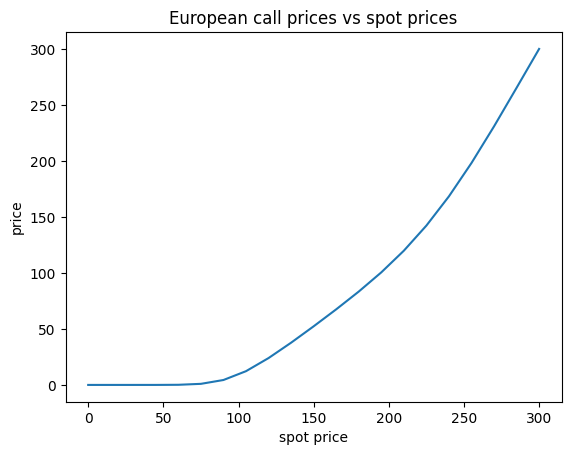

In [22]:
European_call_prices_crank = calculate_prices_crank(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, European_call_prices_crank)

plt.title('European call prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### European put option

In [23]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = True
# Call or Put option
isCall = False
# max S
max_S = 3 * K

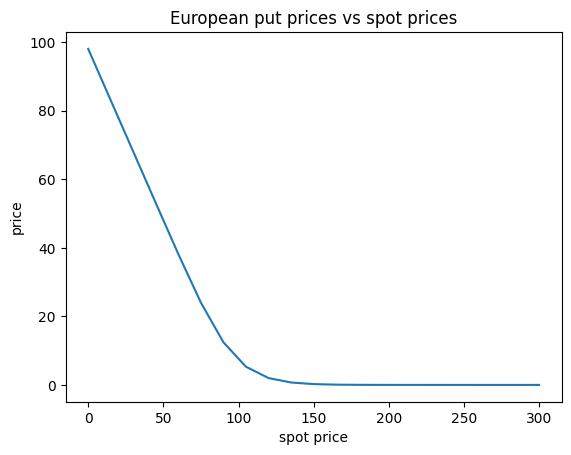

In [24]:
European_put_prices_crank = calculate_prices_crank(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, European_put_prices_crank)

plt.title('European put prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### American call option

In [25]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = False
# Call or Put option
isCall = True
# max S
max_S = 3 * K

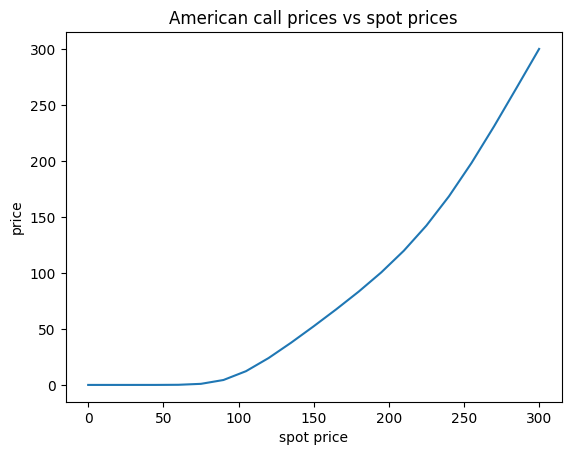

In [26]:
American_call_prices_crank = calculate_prices_crank(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, American_call_prices_crank)

plt.title('American call prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

#### American put option

In [27]:
# maturity time
T = 1
# risk free interest
r = 0.02
# volatility
sigma = 0.2
# exercise price
K = 100
# Divide T into M periods
M = 100
# Divide Stock price into N pieces.
N = 20
# European or American option
isEuropean = False
# Call or Put option
isCall = False
# max S
max_S = 3 * K

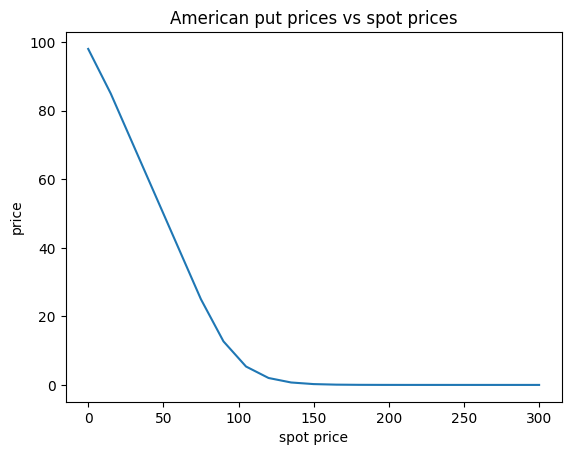

In [28]:
American_put_prices_crank = calculate_prices_crank(T, r, sigma, K, M, N, isEuropean, isCall, max_S)

spot_prices = []
spot_price = 0
step = max_S / N
for i in range(N + 1):
  spot_prices.append(spot_price)
  spot_price += step

plt.plot(spot_prices, American_put_prices_crank)

plt.title('American put prices vs spot prices')
plt.xlabel('spot price')
plt.ylabel('price')

plt.show()
plt.close()

### Comparison

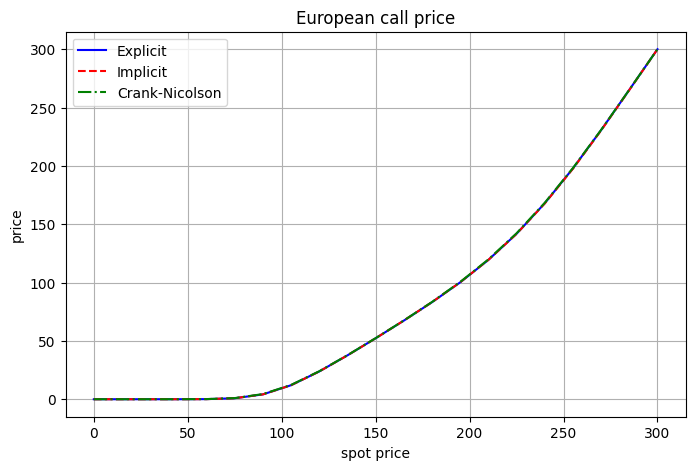

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(spot_prices, European_call_prices_explicit, label='Explicit', linestyle='-', color='b')
plt.plot(spot_prices, European_call_prices_implicit, label='Implicit', linestyle='--', color='r')
plt.plot(spot_prices, European_call_prices_crank, label='Crank-Nicolson', linestyle='-.', color='g')

plt.xlabel('spot price')
plt.ylabel('price')
plt.title('European call price')
plt.legend()
plt.grid()

plt.show()

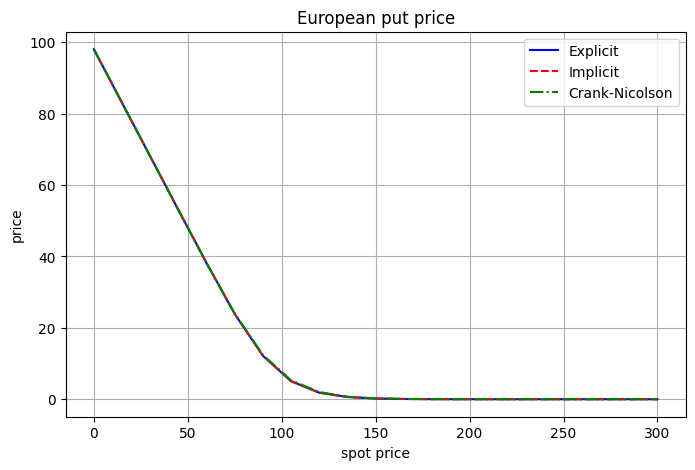

In [30]:
plt.figure(figsize=(8, 5))
plt.plot(spot_prices, European_put_prices_explicit, label='Explicit', linestyle='-', color='b')
plt.plot(spot_prices, European_put_prices_implicit, label='Implicit', linestyle='--', color='r')
plt.plot(spot_prices, European_put_prices_crank, label='Crank-Nicolson', linestyle='-.', color='g')

plt.xlabel('spot price')
plt.ylabel('price')
plt.title('European put price')
plt.legend()
plt.grid()

plt.show()

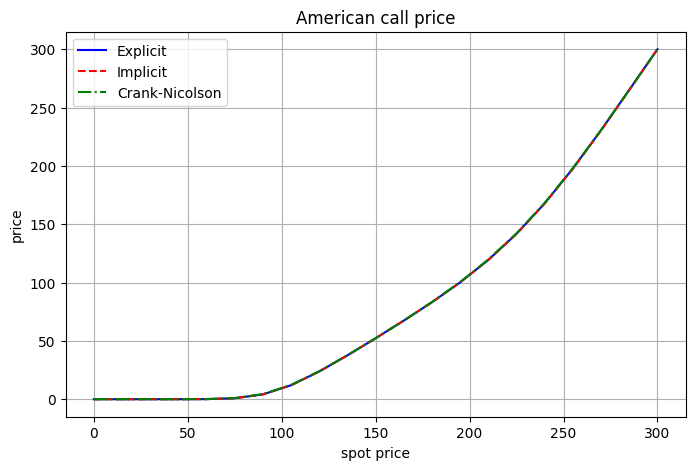

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(spot_prices, American_call_prices_explicit, label='Explicit', linestyle='-', color='b')
plt.plot(spot_prices, American_call_prices_implicit, label='Implicit', linestyle='--', color='r')
plt.plot(spot_prices, American_call_prices_crank, label='Crank-Nicolson', linestyle='-.', color='g')

plt.xlabel('spot price')
plt.ylabel('price')
plt.title('American call price')
plt.legend()
plt.grid()

plt.show()

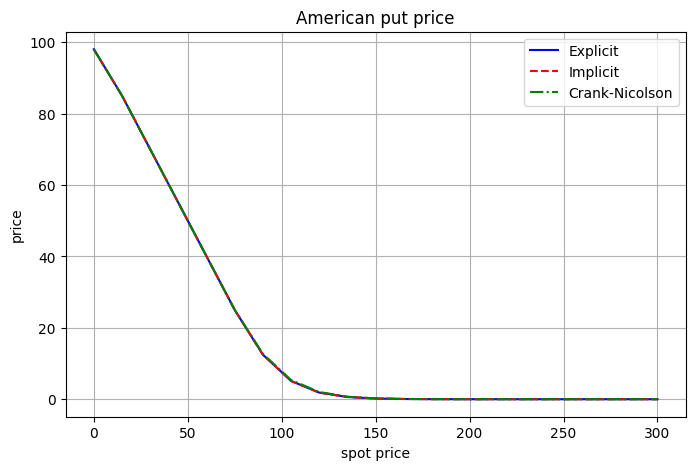

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(spot_prices, American_put_prices_explicit, label='Explicit', linestyle='-', color='b')
plt.plot(spot_prices, American_put_prices_implicit, label='Implicit', linestyle='--', color='r')
plt.plot(spot_prices, American_put_prices_crank, label='Crank-Nicolson', linestyle='-.', color='g')

plt.xlabel('spot price')
plt.ylabel('price')
plt.title('American put price')
plt.legend()
plt.grid()

plt.show()